# K-Means Clustering

En este notebook vamos a utilizar K-Means para agrupar el dataset Iris, el cual contiene las características de tres tipos de flores.

Aunque el dataset contiene la variable respuesta, solo la utilizaremos para comprobar la calidad del resultado de K-Means.

In [2]:
#--vamos a importar el dataset directamente de sklearn
from sklearn.datasets import load_iris

#--importamos la librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


iris = load_iris()
iris['data'][:5,:]

array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.6, 3.1, 1.5, 0.2],
       [5. , 3.6, 1.4, 0.2]])

In [3]:
!pip install pyspark

In [4]:
#--importamos el objeto para cargar la sesion
from pyspark.sql import SparkSession

#--inicializamos la sesion
spark = (SparkSession.builder
  #-especificamos que es local y que utilizamos todos los cores disponibles *
  .master('local[*]')
  #-podemos asignar un nombre a la sesión
  .appName('hello_world_spark')
  .getOrCreate())

El dataset viene en un diccionario por lo que vamos a organizar la información que necesitamos en un pandas dataframe y después lo importamos a un Spark dataframe.

In [7]:
#--pandas dataframe
iris_pd = pd.concat([pd.DataFrame(iris.data, columns=iris.feature_names),
                     pd.DataFrame(iris.target, columns=["label"])], axis=1)
#--spark dataframe
irisDF = spark.createDataFrame(iris_pd)

#--observamos el dataframe
irisDF.show(3)

+-----------------+----------------+-----------------+----------------+-----+
|sepal length (cm)|sepal width (cm)|petal length (cm)|petal width (cm)|label|
+-----------------+----------------+-----------------+----------------+-----+
|              5.1|             3.5|              1.4|             0.2|    0|
|              4.9|             3.0|              1.4|             0.2|    0|
|              4.7|             3.2|              1.3|             0.2|    0|
+-----------------+----------------+-----------------+----------------+-----+
only showing top 3 rows



El iris dataset contiene cuatro atributos pero solo vamos a utilizar dos de ellos, sepal_length y sepal_width, por cuestiones de vizualización.

Los unimos en unsa sola columna usando "VectorAssembler".

In [9]:
from pyspark.ml.feature import VectorAssembler

#--definimos el transformador VectorAssember definiendo el nombre de las columnas de entrada y la columna de salida
vecAssembler = VectorAssembler(inputCols=["sepal length (cm)", "sepal width (cm)"], outputCol="features")
#--creamos un nuevo dataframe que contenga la columna de "features"
irisTwoFeaturesDF = vecAssembler.transform(irisDF)
irisTwoFeaturesDF.show(3)

+-----------------+----------------+-----------------+----------------+-----+---------+
|sepal length (cm)|sepal width (cm)|petal length (cm)|petal width (cm)|label| features|
+-----------------+----------------+-----------------+----------------+-----+---------+
|              5.1|             3.5|              1.4|             0.2|    0|[5.1,3.5]|
|              4.9|             3.0|              1.4|             0.2|    0|[4.9,3.0]|
|              4.7|             3.2|              1.3|             0.2|    0|[4.7,3.2]|
+-----------------+----------------+-----------------+----------------+-----+---------+
only showing top 3 rows



Realizamos la clusterización utilizando Spark

In [10]:
from pyspark.ml.clustering import KMeans

#--definomos el estimador de Kmeans
kmeans = KMeans(k=3, seed=221, maxIter=20)

#--entrenamos el modelo
model = kmeans.fit(irisTwoFeaturesDF)

#--obtenemos el centro de los clusters
centers = model.clusterCenters()

#--clusterizamos cada muestra de nuestro dataset (el mismo training set)
transformedDF = model.transform(irisTwoFeaturesDF)

print(centers)

[array([5.00392157, 3.40980392]), array([6.82391304, 3.07826087]), array([5.8, 2.7])]


En la celda anterior vimos cuales son los centroides obtenidos. Podemos mantener su evolución si corremos la simulación con diferentes número de iteraciones

In [11]:
modelCenters = []
iterations = [0, 2, 4, 7, 10, 20]
for i in iterations:
    kmeans = KMeans(k=3, seed=221, maxIter=i)
    model = kmeans.fit(irisTwoFeaturesDF)
    modelCenters.append(model.clusterCenters())

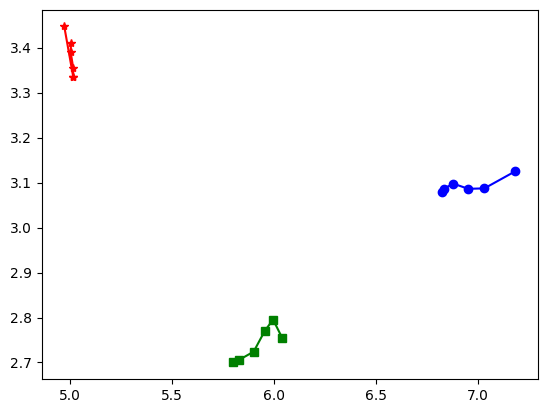

In [12]:
df_centers = pd.DataFrame(np.concatenate(modelCenters), columns=['x','y'])
df_centers['cluster'] = [1,2,3]*len(modelCenters)
# df_centers['cluster'==1]
plt.plot(df_centers.loc[df_centers.cluster==1,:]['x'],
         df_centers.loc[df_centers.cluster==1,:]['y'], 'r-*')
plt.plot(df_centers.loc[df_centers.cluster==2,:]['x'],
         df_centers.loc[df_centers.cluster==2,:]['y'], 'b-o')
plt.plot(df_centers.loc[df_centers.cluster==3,:]['x'],
         df_centers.loc[df_centers.cluster==3,:]['y'], 'g-s')

Observemos cuál es el desempeño de K-Means con respecto a la verdadera clasificación de cada muestra.

Utilizaremos "estrellas" como marcas para el centro de cada cluster.

In [13]:
#--solo una función para darle formato a la figura
import matplotlib.cm as cm

def prepareSubplot(xticks, yticks, figsize=(10.5, 6), hideLabels=False, gridColor='#999999',
                gridWidth=1.0, subplots=(1, 1)):
    plt.close()
    fig, axList = plt.subplots(subplots[0], subplots[1], figsize=figsize, facecolor='white',
                               edgecolor='white')
    if not isinstance(axList, np.ndarray):
        axList = np.array([axList])

    for ax in axList.flatten():
        ax.axes.tick_params(labelcolor='#999999', labelsize='10')
        for axis, ticks in [(ax.get_xaxis(), xticks), (ax.get_yaxis(), yticks)]:
            axis.set_ticks_position('none')
            axis.set_ticks(ticks)
            axis.label.set_color('#999999')
            if hideLabels: axis.set_ticklabels([])
        ax.grid(color=gridColor, linewidth=gridWidth, linestyle='-')
        map(lambda position: ax.spines[position].set_visible(False), ['bottom', 'top', 'left', 'right'])

    if axList.size == 1:
        axList = axList[0]  # Just return a single axes object for a regular plot
    return fig, axList

<ipython-input-14-08e2d6252efa>:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(colorMap)


(1.0, 0.4980392156862745, 0.0, 1.0)
(0.6, 0.6, 0.6, 1.0)
(0.8941176470588236, 0.10196078431372549, 0.10980392156862745, 1.0)


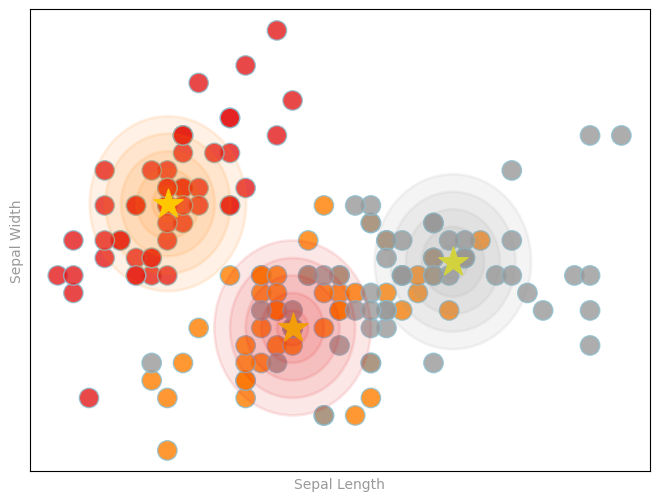

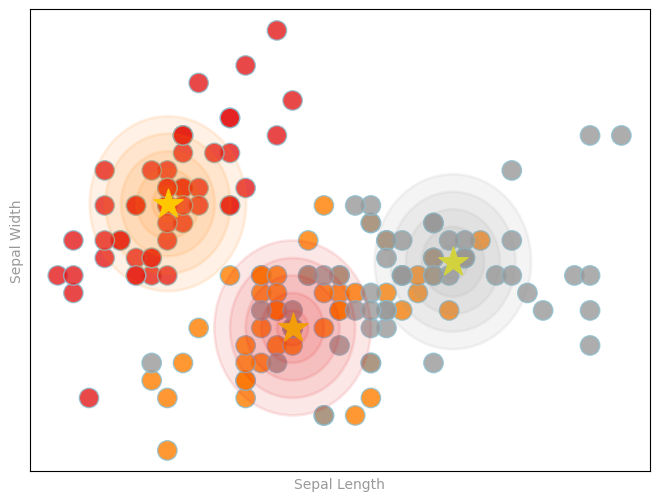

In [14]:
#--seleccionamos las columnas de atributos y la variable respuesta
data = irisTwoFeaturesDF.select("features", "label").collect()
#--separamos la variable respuesta y los atributos
features, labels = zip(*data)

#--volvemos a separar los atributos
x, y = zip(*features)

#--obtenemos los centroides del modelo con 20 iteraciones
centers = modelCenters[5]
#--separamos los centroides en sus coordenadas x,y
centroidX, centroidY = zip(*centers)

colorMap = 'Set1'  #'Set2', 'Set1', 'Dark2', 'winter'

#--ploteamos los puntos y los centroides
fig, ax = prepareSubplot(np.arange(-1, 1.1, .4), np.arange(-1, 1.1, .4), figsize=(8,6))
plt.scatter(x, y, s=14**2, c=labels, edgecolors='#8cbfd0', alpha=0.80, cmap=colorMap)
plt.scatter(centroidX, centroidY, s=22**2, marker='*', c='yellow')
cmap = cm.get_cmap(colorMap)

#--dibujamos circulos alrededor los centroides
colorIndex = [.5, .99, .0]
for i, (x,y) in enumerate(centers):
    print(cmap(colorIndex[i]))
    for size in [.10, .20, .30, .40, .50]:
        circle1=plt.Circle((x,y),size,color=cmap(colorIndex[i]), alpha=.10, linewidth=2)
        ax.add_artist(circle1)

ax.set_xlabel('Sepal Length'), ax.set_ylabel('Sepal Width')
display(fig)

Vamos a ver como los clusters se mueven a cada iteracion

<ipython-input-15-4a290f7f61c4>:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(colorMap)


(1.0, 0.4980392156862745, 0.0, 1.0)
(0.6, 0.6, 0.6, 1.0)
(0.8941176470588236, 0.10196078431372549, 0.10980392156862745, 1.0)
(1.0, 0.4980392156862745, 0.0, 1.0)
(0.6, 0.6, 0.6, 1.0)
(0.8941176470588236, 0.10196078431372549, 0.10980392156862745, 1.0)
(1.0, 0.4980392156862745, 0.0, 1.0)
(0.6, 0.6, 0.6, 1.0)
(0.8941176470588236, 0.10196078431372549, 0.10980392156862745, 1.0)
(1.0, 0.4980392156862745, 0.0, 1.0)
(0.6, 0.6, 0.6, 1.0)
(0.8941176470588236, 0.10196078431372549, 0.10980392156862745, 1.0)
(1.0, 0.4980392156862745, 0.0, 1.0)
(0.6, 0.6, 0.6, 1.0)
(0.8941176470588236, 0.10196078431372549, 0.10980392156862745, 1.0)
(1.0, 0.4980392156862745, 0.0, 1.0)
(0.6, 0.6, 0.6, 1.0)
(0.8941176470588236, 0.10196078431372549, 0.10980392156862745, 1.0)


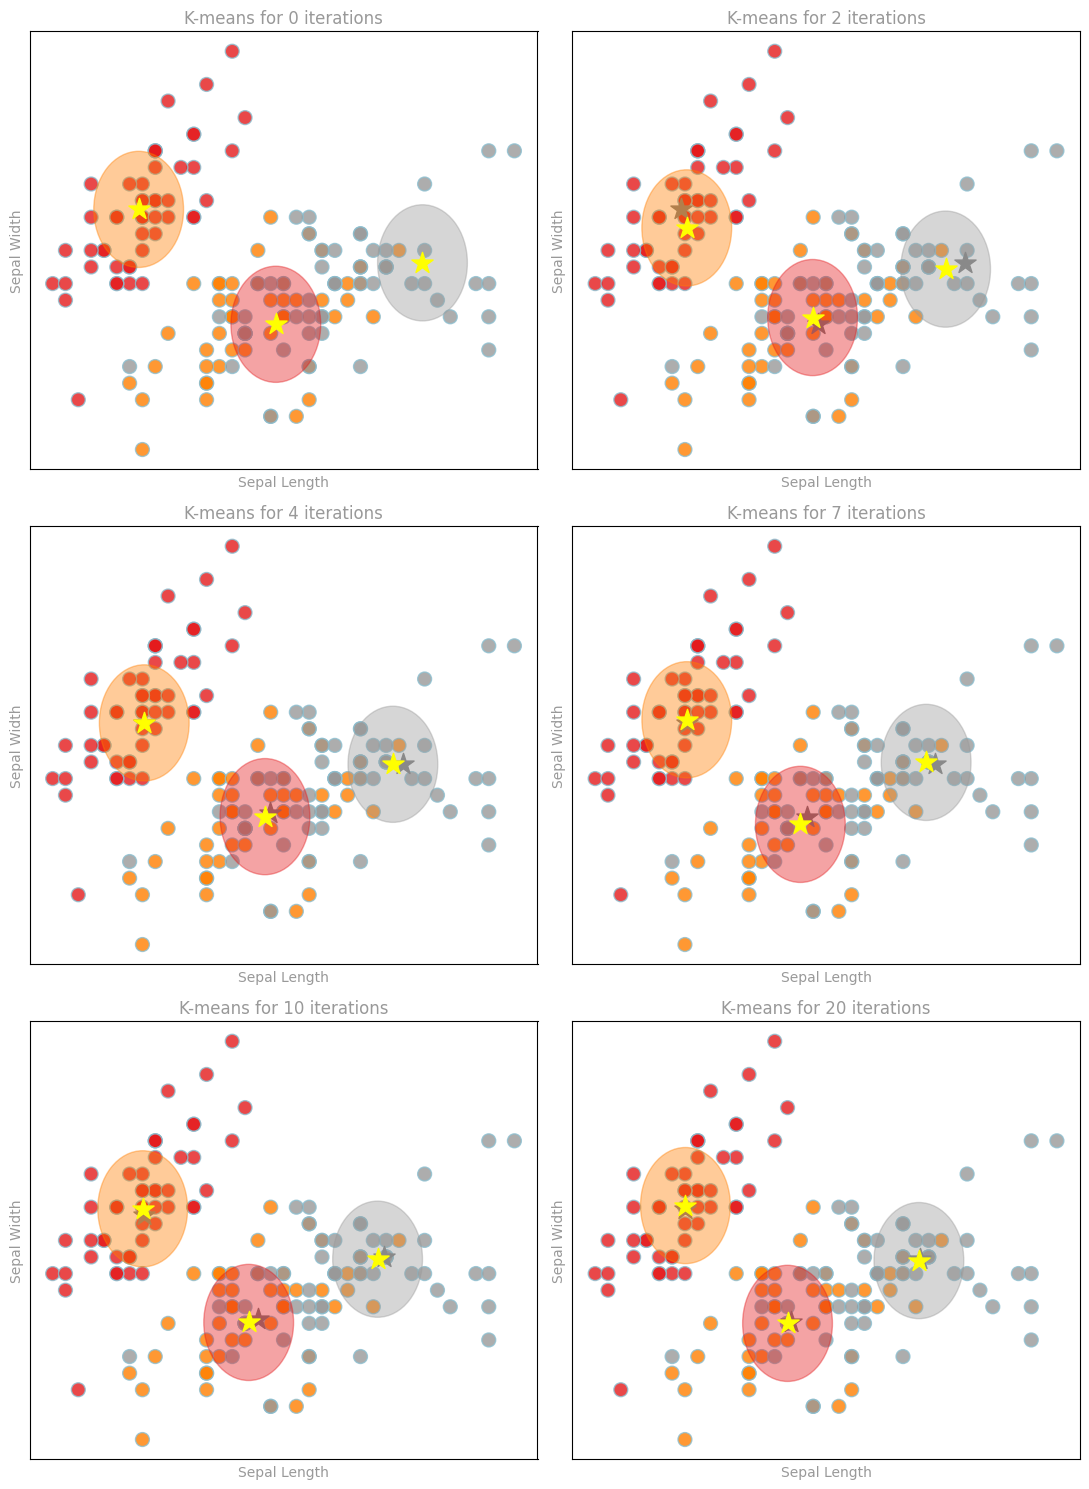

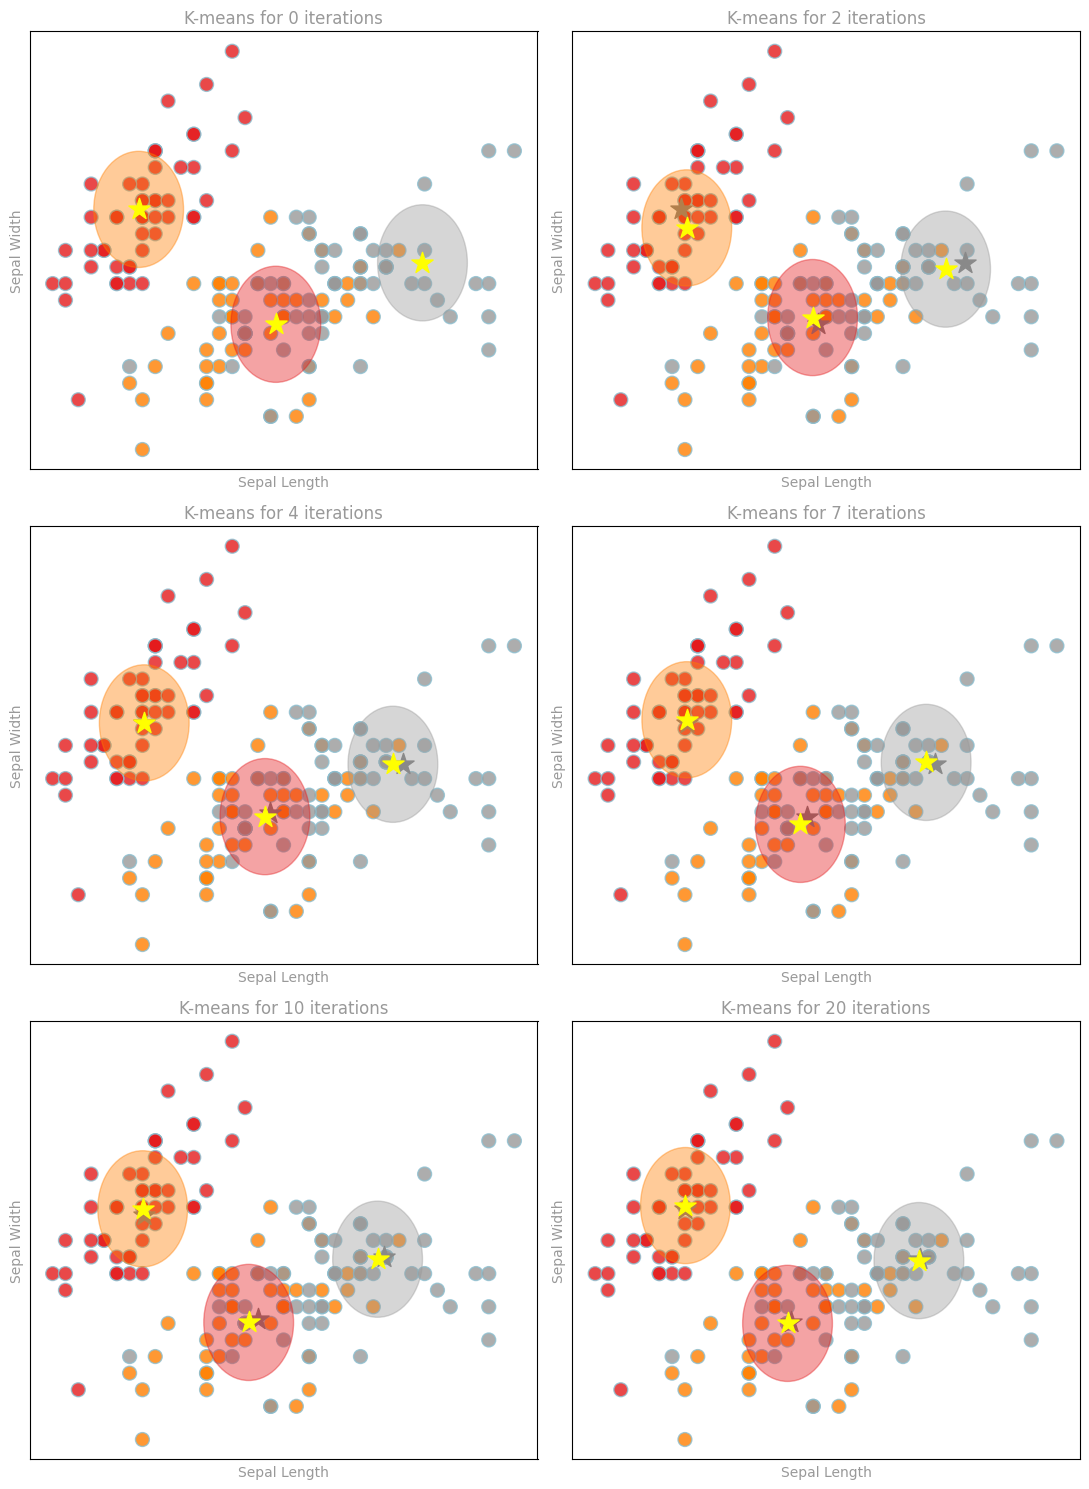

In [15]:

x, y = zip(*features)

oldCentroidX, oldCentroidY = None, None

fig, axList = prepareSubplot(np.arange(-1, 1.1, .4), np.arange(-1, 1.1, .4), figsize=(11, 15),
                             subplots=(3, 2))
axList = axList.flatten()

for i,ax in enumerate(axList[:]):
    ax.set_title('K-means for {0} iterations'.format(iterations[i]), color='#999999')
    centroids = modelCenters[i]
    centroidX, centroidY = zip(*centroids)

    ax.scatter(x, y, s=10**2, c=labels, edgecolors='#8cbfd0', alpha=0.80, cmap=colorMap, zorder=0)
    ax.scatter(centroidX, centroidY, s=16**2, marker='*', c='yellow', zorder=2)
    if oldCentroidX and oldCentroidY:
      ax.scatter(oldCentroidX, oldCentroidY, s=16**2, marker='*', c='grey', zorder=1)
    cmap = cm.get_cmap(colorMap)

    colorIndex = [.5, .99, 0.]
    for i, (x1,y1) in enumerate(centroids):
      print(cmap(colorIndex[i]))
      circle1=plt.Circle((x1,y1),.35,color=cmap(colorIndex[i]), alpha=.40)
      ax.add_artist(circle1)

    ax.set_xlabel('Sepal Length'), ax.set_ylabel('Sepal Width')
    oldCentroidX, oldCentroidY = centroidX, centroidY

plt.tight_layout()

display(fig)

¿Cómo está funcionando K-means detrás de escena?

<img src="https://files.training.databricks.com/images/Mapstage.png" height=200px>

<img src="https://files.training.databricks.com/images/Mapstage2.png" height=500px>

<img src="https://files.training.databricks.com/images/ReduceStage.png" height=500px>

<img src="https://files.training.databricks.com/images/Communication.png" height=500px>